# Regression with an Insurance Dataset - Kaggle
Competition entry by Alex Nicol

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.precision',2)
df = pd.read_csv('dataset/train.csv',index_col=0)
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.60,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.57,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.18,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.94,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.38,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [ ]:
# convert text features to categorical dtype
df.Gender = df.Gender.astype('category')
df['Marital Status'] = df['Marital Status'].astype('category')
df['Education Level'] = df['Education Level'].astype('category')
df['Occupation'] = df['Occupation'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Policy Type'] = df['Policy Type'].astype('category')
df['Customer Feedback'] = df['Customer Feedback'].astype('category')
df['Smoking Status'] = df['Smoking Status'].astype('category')
df['Exercise Frequency'] = df['Exercise Frequency'].astype('category')
df['Property Type'] = df['Property Type'].astype('category')

# previous claims has outliers - mostly N/A, 0, 1, 2. Convert to categorical
df['Previous Claims'] = df['Previous Claims'].clip(0,2).replace({np.nan:'unknown',0:'none',1:'one',2:'two_or_more'})

cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation',
       'Location', 'Policy Type',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type','Previous Claims']

# convert categorical features to binary features, remove redundant features
df = pd.get_dummies(df,columns=cat_cols,drop_first=True)

In [5]:
# check which features have missing values
df.isna().mean().sort_values().tail(10)

Premium Amount                 0.00e+00
Policy Start Date              0.00e+00
Previous Claims_two_or_more    0.00e+00
Insurance Duration             8.33e-07
Vehicle Age                    5.00e-06
Age                            1.56e-02
Annual Income                  3.75e-02
Health Score                   6.17e-02
Number of Dependents           9.14e-02
Credit Score                   1.15e-01
dtype: float64

In [6]:
# convert policy start date to posix timestamp (float value indicating number of seconds since Jan 1 1970 00:00)
# this way, can be treated as another continuous feature
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date']).apply(lambda x: x.timestamp())

In [7]:
df.fillna(df.median(),inplace=True)

## Visualizing distributions of continuous features
Having imputed median values to replace missing data, there is an spike at the location of the median value for Age, Health Score, Credit score.
Age, credit score, vehicle age and policy start date appear to be uniformly distributed. Health score is roughly normally distributed, while annual income and premium amount are right-skewed.

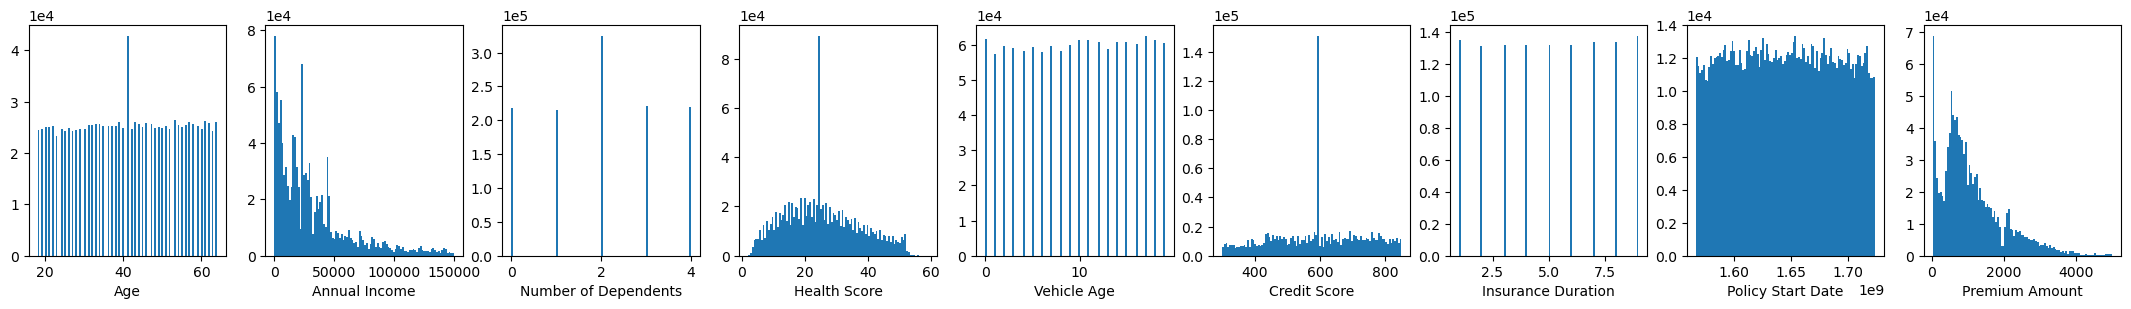

In [8]:
cont_cols = df.select_dtypes('float').columns
plt.figure(figsize=(3*len(cont_cols),3))
for i,c in enumerate(cont_cols):
    plt.subplot(1,len(cont_cols),i+1)
    plt.hist(df[c],bins=100)
    plt.xlabel(c)
    plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

## Checking for highly correlated / redundant features
No pairs of features appear to be highly correlated (R > 0.7). We can try to use all of the features in model development.

<Axes: >

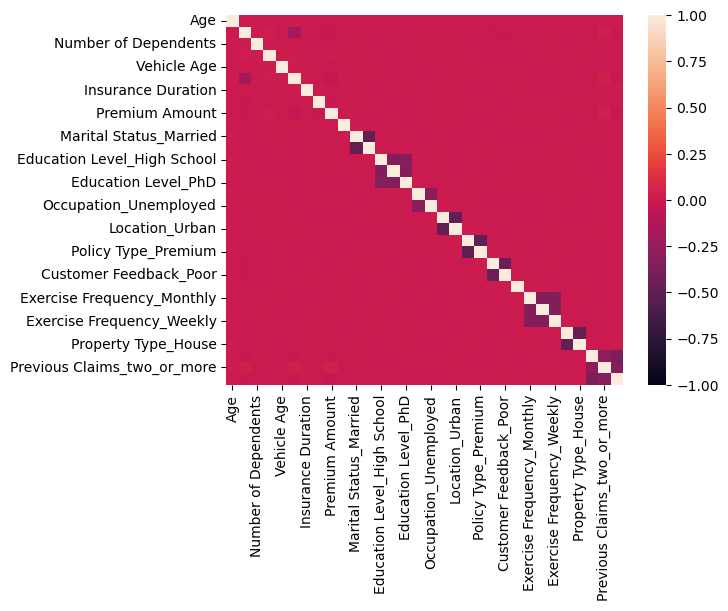

In [9]:
sns.heatmap(df.sample(frac=0.5).corr(),vmin=-1,vmax=1)

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import scipy.stats as stats

In [11]:
target = df['Premium Amount']
# competition metric is root mean square log loss -> log-transform target first so that can use common mean-squares losses to optimize for the root mean square log loss
# will convert back predictions later
transformed_target = np.log1p(target)

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(
    df[[c for c in df.columns if c != 'Premium Amount']],transformed_target,
    random_state=42,test_size=0.3,stratify=pd.qcut(transformed_target,100).cat.codes)
# created a smaller sample of training data (10k samples) for faster grid search optimization
# stratified by quantiles of target to ensure similar distribution
xtrainsub,_,ytrainsub,_ = train_test_split(
    xtrain,ytrain,random_state=42,train_size=10000,stratify=pd.qcut(ytrain,100).cat.codes)

In [23]:
ss = StandardScaler()
pipe = Pipeline([('scaler', StandardScaler()),('model',Lasso())])
param_grid = {'model__alpha':np.logspace(-4,4,30)}
gs = GridSearchCV(pipe, scoring = 'neg_root_mean_squared_error',param_grid=param_grid, cv=5,n_jobs=-1)
param_grid

{'model__alpha': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
        1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
        1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
        2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
        2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
        3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
        4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
        5.29831691e+03, 1.00000000e+04])}

In [24]:
gs.fit(xtrainsub,ytrainsub)
print(gs.best_params_)
print(gs.best_score_)

{'model__alpha': 0.01610262027560939}
-1.089552145294113


In [ ]:
best = gs.best_estimator_
best.fit(xtrain,ytrain)
print('test score:',root_mean_squared_error(ytest, best.predict(xtest)))
# check that reverse-transforming the results gives same score
print('test score:',root_mean_squared_log_error(np.expm1(ytest), np.expm1(best.predict(xtest))))

test score: 1.0893381753654772
test score: 1.0893381753654772


In [36]:
ss = StandardScaler()
pipe = Pipeline([('scaler',StandardScaler()),('model',RandomForestRegressor(n_estimators=50, max_features="sqrt", min_weight_fraction_leaf=0.001,n_jobs=-1))])
param_grid = {'model__min_weight_fraction_leaf':np.logspace(-4,-1,20),
              'model__max_features':[None],
              'model__n_estimators':[100]}
gs = GridSearchCV(pipe, scoring = 'neg_root_mean_squared_error',param_grid=param_grid, cv=3,n_jobs=-1)
param_grid

{'model__min_weight_fraction_leaf': array([0.0001    , 0.00014384, 0.00020691, 0.00029764, 0.00042813,
        0.00061585, 0.00088587, 0.00127427, 0.00183298, 0.00263665,
        0.00379269, 0.00545559, 0.0078476 , 0.01128838, 0.01623777,
        0.02335721, 0.03359818, 0.0483293 , 0.06951928, 0.1       ]),
 'model__max_features': [None],
 'model__n_estimators': [100]}

In [37]:
gs.fit(xtrainsub,ytrainsub)
print(gs.best_params_)
print(gs.best_score_)

{'model__max_features': None, 'model__min_weight_fraction_leaf': 0.005455594781168515, 'model__n_estimators': 100}
-1.073473262555671


In [38]:
best = gs.best_estimator_
best.fit(xtrain,ytrain)
print('test score:',root_mean_squared_error(ytest, best.predict(xtest)))
# check that reverse-transforming the results gives same score
print('test score:',root_mean_squared_log_error(np.expm1(ytest), np.expm1(best.predict(xtest))))

test score: 1.0546518730913992
test score: 1.0546518730913992


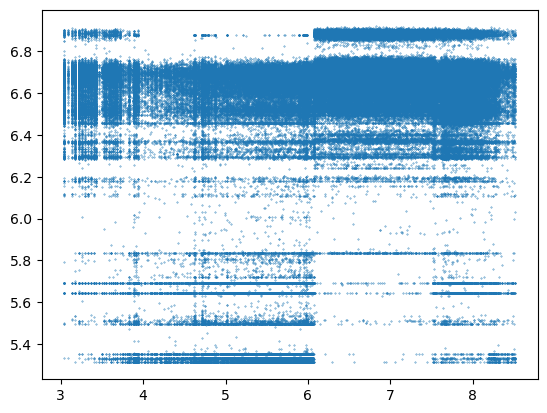

In [ ]:
plt.scatter(ytest, ytest-best.predict(xtest),s=0.1)

In [52]:
pd.Series(best[-1].feature_importances_, index=[c for c in df.columns if c != 'Premium Amount']).sort_values().tail(10)

Number of Dependents           4.72e-04
Vehicle Age                    7.63e-04
Age                            9.34e-04
Customer Feedback_Good         6.63e-03
Customer Feedback_Poor         8.59e-03
Policy Start Date              5.42e-02
Previous Claims_two_or_more    1.43e-01
Health Score                   1.99e-01
Credit Score                   2.43e-01
Annual Income                  3.41e-01
dtype: float64

In [14]:
pipe = Pipeline([('scaler',StandardScaler()),('model',AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50,))])
param_grid = {'model__estimator__min_weight_fraction_leaf':np.logspace(-5,-3,10),
              'model__n_estimators':[100],
              'model__learning_rate':[0.01,0.1,1],
              'model__estimator__max_depth':[None]}
gs = GridSearchCV(pipe, scoring = 'neg_root_mean_squared_error',param_grid=param_grid, cv=3)
param_grid

{'model__estimator__min_weight_fraction_leaf': array([1.00000000e-05, 1.66810054e-05, 2.78255940e-05, 4.64158883e-05,
        7.74263683e-05, 1.29154967e-04, 2.15443469e-04, 3.59381366e-04,
        5.99484250e-04, 1.00000000e-03]),
 'model__n_estimators': [100],
 'model__learning_rate': [0.01, 0.1, 1],
 'model__estimator__max_depth': [None]}

In [30]:
gs.fit(xtrainsub,ytrainsub)
print(gs.best_params_)
print(gs.best_score_)

{'model__estimator__max_depth': None, 'model__estimator__min_weight_fraction_leaf': 0.001, 'model__learning_rate': 0.01, 'model__n_estimators': 100}
-1.0838944378483386


In [15]:
best = gs.best_estimator_
best.fit(xtrain,ytrain)
print('test score:',root_mean_squared_error(ytest, best.predict(xtest)))
# check that reverse-transforming the results gives same score
print('test score:',root_mean_squared_log_error(np.expm1(ytest), np.expm1(best.predict(xtest))))

KeyboardInterrupt: 

In [16]:
best = pipe
best.set_params(**{'model__estimator__max_depth': None, 'model__estimator__min_weight_fraction_leaf': 0.001, 'model__learning_rate': 0.01, 'model__n_estimators': 100})
best.fit(df[xtrain.columns],transformed_target)
print('train score:',root_mean_squared_error(transformed_target, best.predict(df[xtrain.columns])))

train score: 1.0485645392273104


In [17]:
sample_submission = pd.read_csv('dataset/test.csv',index_col=0)

In [18]:
# convert text features to categorical dtype
sample_submission.Gender = sample_submission.Gender.astype('category')
sample_submission['Marital Status'] = sample_submission['Marital Status'].astype('category')
sample_submission['Education Level'] = sample_submission['Education Level'].astype('category')
sample_submission['Occupation'] = sample_submission['Occupation'].astype('category')
sample_submission['Location'] = sample_submission['Location'].astype('category')
sample_submission['Policy Type'] = sample_submission['Policy Type'].astype('category')
sample_submission['Customer Feedback'] = sample_submission['Customer Feedback'].astype('category')
sample_submission['Smoking Status'] = sample_submission['Smoking Status'].astype('category')
sample_submission['Exercise Frequency'] = sample_submission['Exercise Frequency'].astype('category')
sample_submission['Property Type'] = sample_submission['Property Type'].astype('category')

# previous claims has outliers - mostly N/A, 0, 1, 2. Convert to categorical
sample_submission['Previous Claims'] = sample_submission['Previous Claims'].clip(0,2).replace({np.nan:'unknown',0:'none',1:'one',2:'two_or_more'})

cat_cols = ['Gender','Marital Status', 'Education Level', 'Occupation',
       'Location', 'Policy Type',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type','Previous Claims']

# convert categorical features to binary features, remove redundant features
sample_submission = pd.get_dummies(sample_submission,columns=cat_cols,drop_first=True)
sample_submission['Policy Start Date'] = pd.to_datetime(sample_submission['Policy Start Date']).apply(lambda x: x.timestamp())
sample_submission.fillna(sample_submission.median(),inplace=True)

In [19]:
pred = np.expm1(best.predict(sample_submission))

In [23]:
pd.DataFrame().from_dict({'id':sample_submission.index,'Premium Amount':pred}).to_csv('my_sample_submission.csv',index=False)